# Retirement Model

This is a retirement model which models salary with both a constant growth rate for cost of living raises as well as regular salary increases for promotions. The model is broken up into the following sections:

- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Salaries**](#Salaries): Determining the salary in each year, considering cost of living raises and promotions
- [**Wealths**](#Wealths): Determining the wealth in each year, considering a constant savings rate and investment rate
- [**Retirement**](#Retirement): Determines years to retirement from the wealths over time, the main output from the model.

# Setup

Setup for the later calculations are here. The necessary packages are imported.


In [1]:
from dataclasses import dataclass
import pandas as pd

# Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [2]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    desired_cash = None
    annual_cash_spend_in_retirement: int = 40000
    years_in_retirement: int = 25

model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, annual_cash_spend_in_retirement=40000, years_in_retirement=25)

In [3]:
data = model_data

## Salaries

Here the salary for each year is calculated. We assume that the salary grows at a constant rate each year for cost of living raises, and then also every number of years, the salary increases by a further percentage due to a promotion or switching jobs. Based on this assumption, the salary would evolve over time with the following equation:

$$s_t = s_0 (1 + r_{cl})^n (1 + r_p)^p$$

Where:
- $s_t$: Salary at year $t$
- $s_0$: Starting salary (year 0)
- $r_{cl}$: Annual cost of living raise
- $r_p$: Promotion raise
- $p$: Number of promotions

And in Python format:

In [4]:
def salary_at_year(data: ModelInputs, year: int) -> float:
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """

    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos

    return salary_t

That function will get the salary at a given year, so to get all the salaries we just run it on each year. But we will not know how many years to run as we should run it until the individual is able to retire. So we are just showing the first few salaries for now and will later use this function in the [Wealths](#Wealths) section of the model.

In [5]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


As expected, with the default inputs, the salary is increasing at 2% per year. Then at year 5, there is a promotion so there is a larger increase in salary.

## Wealths

The wealths portion of the model is concerned with applying the savings rate to the earned salary to calculate the cash saved, accumulating the cash saved over time, and applying the investment rate to the accumulated wealth.

To calculate cash saved, it is simply:

$$c_t = s_t * r_s$$

Where:
- $c_t$: Cash saved during year $t$
- $r_s$: Savings rate

In [6]:
def cash_saved_during_year(data: ModelInputs, year: int) -> float:
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """

    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate

    return cash_saved

To get the wealth at each year, it is just applying the investment return to last year's wealth, then adding this year's cash saved:

$$w_t = w_{t-1} (1 + r_i) + c_t$$
Where:
- $w_t$: Wealth at year $t$
- $r_i$: Investment rate

In [7]:
def wealth_at_year(data: ModelInputs, year: int, prior_wealth: float) -> float:
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """

    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved

    return wealth

Again, just like in the [Salaries](#Salaries) section, we can now get the output for each year, but we don't know ultimately how many years we will have to run it. That will be determined in the [Retirement](#Retirement) section. So for now, just show the first few years of wealth accumulation:

In [8]:
prior_wealth = 0  # starting with no cash saved

for i in range(6):
    year = i + 1
    wealth = wealth_at_year(data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.


With default inputs, the wealth is going up by approximately 25% of the salary each year, plus a bit more for investment. Then in year 6 we see a substantially larger increase because the salary is substantially larger due to the promotion. So everything is looking correct.

## Retirement

This section of the model puts everything together to produce the final output of years to retirement. It uses the logic to get the wealths at each year, which in turn uses the logic to the get salary at each year. The wealth at each year is tracked over time until it hits the desired cash. Once the wealth hits the desired cash, the individual is able to retire so that year is returned as the years to retirement.

To calculate the desired cash we use the following function:

In [9]:
def desired_cash_calc():

    dc = 0

    for _ in range(data.years_in_retirement):
        dc += data.annual_cash_spend_in_retirement + (1+data.interest_rate)
    
    return dc

And now we can calculate the years to retirement:

In [10]:
def years_to_retirement(data: ModelInputs) -> int:
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    print('Wealths over time:') # \n makes a blank line in the output.

    data.desired_cash = desired_cash_calc()

    while wealth < data.desired_cash:
        year += 1
        wealth = wealth_at_year(data, year, prior_wealth)
        print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.

    return year

With the default inputs:

In [11]:
years = years_to_retirement(data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.
The wealth at year 19 is $672,557.
The wealth at year 20 is $745,168.
The wealth at year 21 is $822,190.
The wealth at year 22 is $903,859.
The wealth at year 23 is $990,422.
The wealth at year 24 is $1,082,140.

Retirement:
It will take 24 years to retire.


With custom inputs:

In [12]:
# custom_years = years_to_retirement(ModelInputs(starting_salary=10000, cost_of_living_raise=0.04))

# Results Summary

## Put Results in a Table

Now I will visualize the salaries and wealths over time. First create a function which runs the model to put these results in a DataFrame.

In [13]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(model_data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
        # Save the results in a tuple for later building the DataFrame
        df_data_tups.append((year, salary, wealth))
        
    # Now we have exited the while loop, so wealth must be >= desired_cash
    
    # Now create the DataFrame
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

Also set up a function which formats the `DataFrame` for display.

In [14]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

Now call the function to save the results into the `DataFrame`.

In [15]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$61,200.00","$15,300.00"
1,2,"$62,424.00","$31,671.00"
2,3,"$63,672.48","$49,172.67"
3,4,"$64,945.93","$67,867.79"
4,5,"$76,181.58","$90,306.57"
5,6,"$77,705.21","$114,248.20"
6,7,"$79,259.31","$139,775.44"
7,8,"$80,844.50","$166,975.33"
8,9,"$82,461.39","$195,939.45"
9,10,"$96,727.21","$229,918.22"


## Plot Results

Now I will visualize the salaries and wealths over time.

<AxesSubplot:xlabel='Year'>

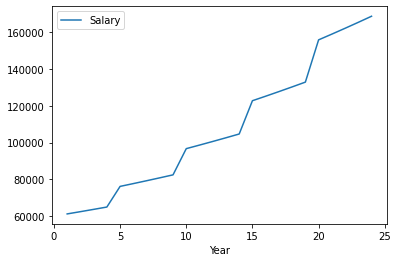

In [16]:
df.plot.line(x='Year', y='Salary')

### Wealths over Time

<AxesSubplot:xlabel='Year'>

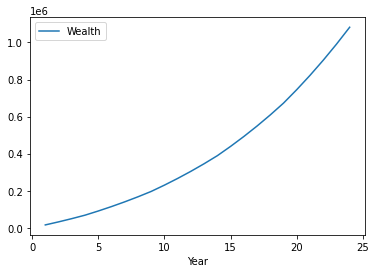

In [17]:
df.plot.line(x='Year', y='Wealth')